# Regression with Multiple Features

TO DO
- Nothing for the moment.

**ACKNOWLEDGEMENT**

**The dataset used in this notebook is from Andrew Ng's course on Machine Learning on Coursera.**

In [1]:
# Share functions used in multiple notebooks
%run Shared-Functions.ipynb

In [2]:
# Import our usual libraries
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib inline

## The Business Problem: Predicting Housing Prices

What's the market value of a house? One way to determine the market price is to collect up the prices of houses based on a few characteristics such as size in square feet and number of bedrooms. Then think like a machine and "learn" what the price should be based on this data.

The data we have is our familiar dataset of housing prices in Portland, Oregon. Let's refresh our memories of what this dataset looks like.

## Load the Data

In [3]:
import os
# OS-independent way to navigate the file system
# Data directory is one directory up in relation to directory of this notebook
data_dir_root = os.path.normpath(os.getcwd() + os.sep + os.pardir)
# Where the file is
file_url = data_dir_root + os.sep + "Data" + os.sep + "portland-house-prices.txt"
# Load the data into a dataframe
data2 = pd.read_csv(file_url, header=None, names=['Size', 'Bedrooms', 'Price'])
data2.head()

,Size,Bedrooms,Price
0,2104,3,399900
1,1600,3,329900
2,2400,3,369000
3,1416,2,232000
4,3000,4,539900


In [4]:
data2.describe()

,Size,Bedrooms,Price
count,47.000000,47.000000,47.000000
mean,2000.680851,3.170213,340412.659574
std,794.702354,0.760982,125039.899586
min,852.000000,1.000000,169900.000000
25%,1432.000000,3.000000,249900.000000
50%,1888.000000,3.000000,299900.000000
75%,2269.000000,4.000000,384450.000000
max,4478.000000,5.000000,699900.000000


In [5]:
data2.Size.min()

852

We have information about 47 homes in this dataset. Each house is described by two characteristics or "features".

## Step 1: Visualize the Data

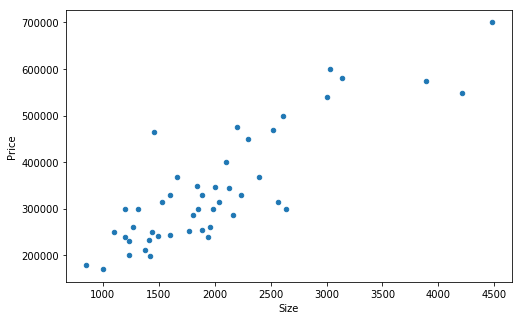

In [6]:
data2.plot.scatter(x='Size', y='Price', figsize=(8,5))

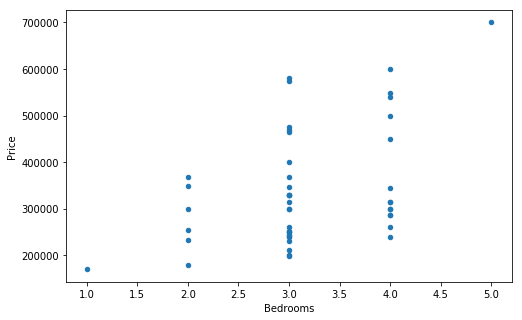

In [7]:
data2.plot.scatter(x='Bedrooms', y='Price', figsize=(8,5))

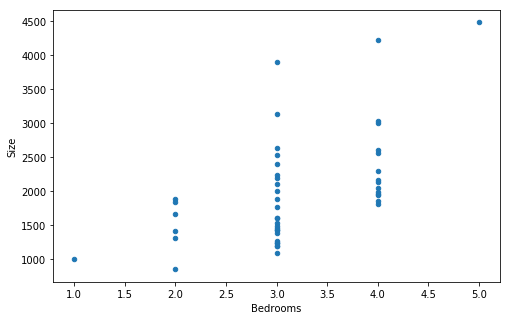

In [8]:
data2.plot.scatter(x='Bedrooms', y='Size', figsize=(8,5))

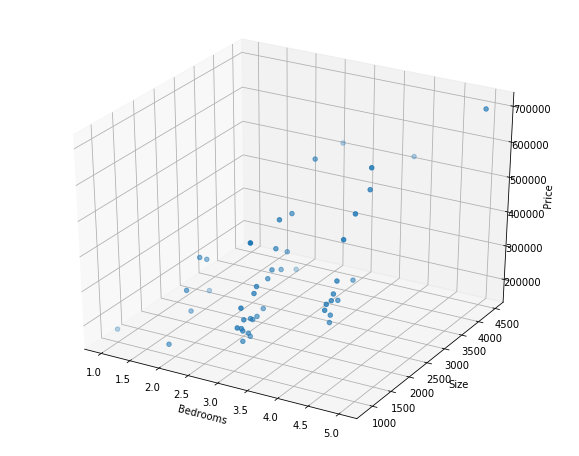

In [10]:
# 3D scatter plot
from mpl_toolkits.mplot3d import Axes3D
threeD = plt.figure(figsize=(10,8)).gca(projection='3d')
threeD.scatter(data2['Bedrooms'], data2['Size'], data2['Price'])
threeD.set_xlabel('Bedrooms')
threeD.set_ylabel('Size')
threeD.set_zlabel('Price')
plt.show()

## Rescale/Normalize the Data
Notice that the size of a house in square feet is about 1,000 times the number of bedrooms it has. Similarly, the price of a house is about 100 times the size of the house. This is quite common in many datasets, but when it happens, the iterative method of gradient descent (which we'll use again) becomes inefficient. This is simply a matter of making the computations efficient. To do so, we'll do something called *feature normalization*.

In [11]:
# Normalize the dataset
data2Norm = (data2 - data2.mean()) / data2.std()
data2Norm.head()

,Size,Bedrooms,Price
0,0.130010,-0.223675,0.475747
1,-0.504190,-0.223675,-0.084074
2,0.502476,-0.223675,0.228626
3,-0.735723,-1.537767,-0.867025
4,1.257476,1.090417,1.595389


In [12]:
# Let's keep track of the mean and standard deviation of the house sizes, number of bedrooms, and prices in the dataset.
# We'll need these values when we make predictions

# We can get them easily for size, bedrooms and price by using data2.mean()[0], ..., [2]
data2.mean()[0], data2.mean()[1], data2.mean()[2], data2.std()[0], data2.std()[1], data2.std()[2]

(2000.6808510638298,
 3.1702127659574466,
 340412.6595744681,
 794.70235353388966,
 0.76098188678009993,
 125039.89958640098)

## Step 2: Define the Task You Want to Accomplish

### Step 2a: Identify the Inputs
In this case we have 2 inputs -- the size and number of bedrooms of the house. 

In [13]:
# Number of columns in the dataset
cols = data2Norm.shape[1]
# Inputs are our first two columns
X = data2Norm.iloc[:, 0:cols-1]
# Add an initial column of 1s to X to keep the notation simple
# X.insert(0,'x0',1)

In [14]:
X.head()

,Size,Bedrooms
0,0.130010,-0.223675
1,-0.504190,-0.223675
2,0.502476,-0.223675
3,-0.735723,-1.537767
4,1.257476,1.090417


### Step 2b: Identify the Output
The output is the house price. Let's set it up as a variable y.

In [15]:
# The output
y = data2Norm.iloc[:, cols-1:cols]

In [16]:
y.head()

,Price
0,0.475747
1,-0.084074
2,0.228626
3,-0.867025
4,1.595389


## Step 3: Define the Model

### Step 3a: Define the Features

In this case our features are exactly the same as our inputs. We have 2 features: the size of a house in square feet and the number of bedrooms a house has. These are the features encoded in the variables $x_{1}$ and $x_{2}$.

Later we'll see models where the features and the inputs are not one and the same. In these cases the features are constructed by combining inputs in various ways.

### Step 3b: Transform the Inputs Into an Output

We're going to stick to a simple model -- exactly the same one as before but now with an additional feature.

$$y = h_{W}(X) = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

It's still linear but now has more than 1 variable, hence the $x_{2}$.

### Step 3c: Clarify the Parameters of the Model

$w_{0}$, $w_{1}$, and $w_{2}$ are the *parameters* of the model. These parameters can each take on an infinite number of values. In other words they are continuous variables. $w_{0}$ is called the *bias value*.

With this model, we know exactly how to transform an input into an output -- that is, once the values of the parameters are given.

Let's pick a value of X from the dataset, fix a specific value for $w_{0}$ and $w_{1}$, and see what we get for the value of y.

Specifically, let
$\begin{bmatrix}
w_{0} \\
w_{1} \\
w_{2}
\end{bmatrix} = 
\begin{bmatrix}
-10 \\
1 \\
0
\end{bmatrix}$

This means $w_{0}$ is -10, $w_{1}$ is 1, and $w_{2}$ is 0.

Let's try out X * W for the first few rows of X.

In [17]:
# X * W for the first 5 rows of X
df_addOnes(X.iloc[0:5]) * np.matrix('-10;1;0')

matrix([[ -9.86999013],
        [-10.50418984],
        [ -9.49752364],
        [-10.73572306],
        [ -8.74252398]])

In [18]:
# Outputs generated by our model for the first 5 inputs with the specific theta values below
W_init = [-1, 1.4, 0.5]
learning_rate = 0.001 # the learning rate
num_iters = 10 # number of iterations

In [19]:
W_opt, final_penalty, running_w, running_penalty = gradientDescent(X, y, W_init, num_iters, learning_rate)

In [20]:
y[0:5]

,Price
0,0.475747
1,-0.084074
2,0.228626
3,-0.867025
4,1.595389


In [21]:
# Compare these outputs to the actual values of y in the dataset
# Here's the difference between 
(df_addOnes(X.iloc[0:5]) * np.matrix(W_opt))

matrix([[-0.91908207],
        [-1.80187615],
        [-0.40061571],
        [-2.77046592],
        [ 1.29662949]])

That's quite a bit off from the actual values; so we know that the values for $W$ in $W_{opt}$ must be quite far from the optimal values for $W$ -- the values that will minimize the cost of getting it wrong.

## Step 4: Define the Penalty for Getting it Wrong
Our cost function is exactly the same as it was before for the single variable case. 

The cost of getting it wrong is defined as a function $J(W)$:

$$J(W) = \frac{1}{2m} \sum_{i=1}^{m} (h_{w}x^{(i)}) - y^{(i)})^2$$

The only difference from what we had before is in $h_{W}(x)$ which as a $w_{2}$ and $x_{2}$ now added as we saw above

$$h_{W}(X) = w_{0} * x_{0}\ +\ w_{1} * x_{1} +\ w_{2} * x_{2}$$

In [22]:
# Compute the cost for a given set of W values over the entire dataset
# Get X and y in to matrix form
penalty(X, y, W_init, squaredPenalty)

1.0665476022595193

We don't know yet if this is high or low -- we'll have to try out a whole bunch of $W$ values. Or better yet, we can use pick an iterative method and implement it.

## Step 5: Find the Parameter Values that Minimize the Penalty

Once again, the method that will "learn" the optimal values for $W$ is gradient descent. We don't have to do a thing to the function we wrote before for gradient descent. Let's use it to find the minimum cost and the values of $W$ that result in that minimum cost.

In [23]:
# Set hyper-parameters
num_iters = 1000 # number of iterations
learning_rate = 0.001 # the learning rate
learning_rates = [0.001, 0.001, 0.003, 0.01, 0.03, 0.1]

In [24]:
# Run gradient descent and capture the progression of cost values and the ultimate optimal W values
%time W_opt, final_penalty, running_w, running_penalty = gradientDescent(X, y, W_init, num_iters, learning_rate)
# Get the optimal theta values and the last few cost values
W_opt, final_penalty, running_w[-5:], running_penalty[-5:]

CPU times: user 286 ms, sys: 6.95 ms, total: 293 ms
Wall time: 303 ms


(matrix([[-0.36769542],
         [ 0.98830744],
         [ 0.07520094]]),
 659732.50716359541,
 [(matrix([[-0.36916989]]), matrix([[ 0.98899692]]), matrix([[ 0.07593288]])),
  (matrix([[-0.36880072]]), matrix([[ 0.98882414]]), matrix([[ 0.07574948]])),
  (matrix([[-0.36843192]]), matrix([[ 0.98865164]]), matrix([[ 0.07556636]])),
  (matrix([[-0.36806349]]), matrix([[ 0.98847941]]), matrix([[ 0.07538352]])),
  (matrix([[-0.36769542]]), matrix([[ 0.98830744]]), matrix([[ 0.07520094]]))],
 array([ 665034.1969773 ,  663704.79361754,  662378.0477351 ,
         661053.95401768,  659732.5071636 ]))

In [25]:
gdResults = [gradientDescent(X, y, W_init, num_iters, learning_rates[i]) for i in range(len(learning_rates))]

In [26]:
penalty_list = [gdResults[i][3] for i in range(len(gdResults))]
penalty_list[0]

array([ 4869926.517681  ,  4860191.53457215,  4850476.01169454,
        4840779.91014716,  4831103.19110678,  4821445.81582776,
        4811807.74564192,  4802188.94195838,  4792589.36626341,
        4783008.98012025,  4773447.74516899,  4763905.6231264 ,
        4754382.57578576,  4744878.56501677,  4735393.5527653 ,
        4725927.50105332,  4716480.37197872,  4707052.12771513,
        4697642.73051183,  4688252.14269353,  4678880.32666029,
        4669527.2448873 ,  4660192.85992477,  4650877.13439778,
        4641580.03100611,  4632301.51252413,  4623041.5418006 ,
        4613800.08175854,  4604577.0953951 ,  4595372.54578141,
        4586186.39606239,  4577018.60945666,  4567869.14925636,
        4558737.978827  ,  4549625.06160732,  4540530.36110917,
        4531453.84091731,  4522395.46468932,  4513355.1961554 ,
        4504332.99911829,  4495328.83745305,  4486342.67510698,
        4477374.47609944,  4468424.20452172,  4459491.82453688,
        4450577.30037963,  4441680.59635

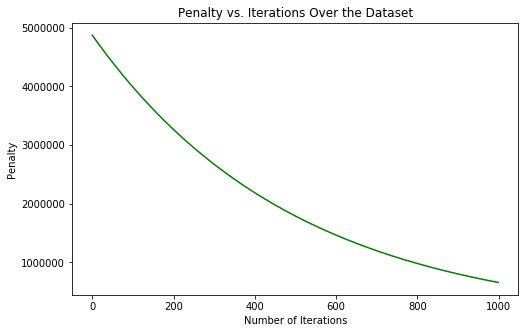

In [27]:
# How the penalty changes as the number of iterations increase
fig, ax = plt.subplots(figsize=(8,5))
ax.plot(np.arange(num_iters), running_penalty, 'g')
ax.set_xlabel('Number of Iterations')
ax.set_ylabel('Penalty')
ax.set_title('Penalty vs. Iterations Over the Dataset')

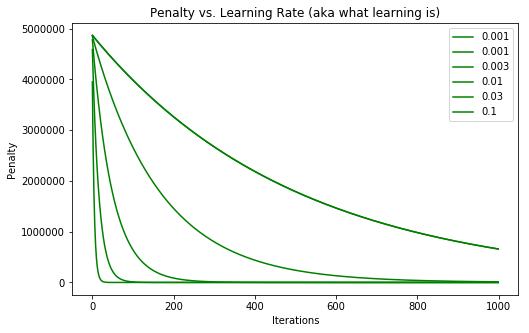

In [31]:
# How the cost of the transformation varies with the learning rate
fig, ax = plt.subplots(figsize=(8,5))
[ax.plot(np.arange(num_iters), penalty_list[i], 'g', label=learning_rates[i]) for i in range(len(learning_rates))]
ax.set_xlabel('Iterations')
ax.set_ylabel('Penalty')
ax.legend()
ax.set_title('Penalty vs. Learning Rate (aka what learning is)')

## Step 6: Use the Model and Optimal Parameter Values to Make Predictions

It looks like a learning rate ($\alpha$ value) greater than 0.003 is good enough to get our iterative gradient descent to plunge down to arrive at the lowest cost value and stay there. 

Let's make some predictions...What is our prediction for a house that is 5,000 square feet in size with 4 bedrooms? Let's plug these in to our model and use the optimal $\theta$ values we've calculated above.

In [32]:
# Change size and num_bedrooms to make distinct predictions
size = 5000
num_bedrooms = 5

# Remember we've run the model using rescaled house sizes and number of bedrooms
# So we should scale the inputs down and then scale the prediction up when we're done
size_scaled = (size - data2.mean()[0])/data2.std()[0]
beds_scaled = (num_bedrooms - data2.mean()[1])/data2.std()[1]

# This is our model -- we're just using it here to make a calculation
pred_price = (W_opt[0] * 1) + (W_opt[1] * size_scaled) + (W_opt[2] * beds_scaled)

# Now we re-re-scale the price to convert it back to the right order of magnitude
pred_price_real = (pred_price * data2.std()[2]) + data2.mean()[2]

# Format and print the result
print("Predicted Price: ", '${:20,.0f}'.format(math.ceil(pred_price_real)))

Predicted Price:  $             783,447


You'll notice that the predicted prices are mostly driven by the size of the house; the number of bedrooms don't matter as much.

## Step 7: Measure the Performance of the Model

We're going to delay this step until later on in the course.

## Summary

Regression with more than one feature is just as straightforward to implement as regression with one feature. Having more features makes it harder to visualize the penalty surface (three or more parameters means we'd have to produce 4-dimensional plots -- which are not impossible but harder to do). Also, having more features makes it a more intense optimization problem; but thankfully, computers are especially good at this sort of thing.

In fact, it would be quite difficult to write efficient versions of gradient descent for large optimization problems. Again, thankfully, this is a vast areas of research in applied mathematics (numerical computational techniques) and computer science (algorithm design). We will soon be tapping into this work and use highly efficient numerical computation techniques and algorithms to crunch through our machine learning problems.

The concepts of machine learning and the 7 steps -- what it is how machines/software programs are able to do it -- remain the same throughout. To recap, we learned about the following:
- dataset inputs, features, and outputs
- the model for transforming features into outputs and its parameters
- the penalty for straying from the correct output
- the algorithm for finding the optimal values of the parmeters (the algorithm for "learning" the optimal parameters)
- the "hyperparameters" of the learning algorithm -- learning rate and number of iterations over the entire dataset
- making predictions based on the learned optimal values of the model parameters